In [1]:
# !pip install -Uqq duckduckgo_search

In [2]:
from pathlib import Path
from time import sleep

from duckduckgo_search import ddg_images
from fastcore.all import *

In [3]:
def search_images(term, max_images=200):
    return L(ddg_images(term, max_results=max_images)).itemgot("image")

In [4]:
urls = search_images("baseball bat", max_images=1)
urls[0]

'https://i5.walmartimages.com/asr/db58db17-4ccd-4c13-b46f-3c9fb3e062e0_1.37902d6185c021734c35acfe653cc7d9.jpeg'

## Instead of bird and forest, it is cricket bat vs baseball bat vs tennis racket

In [5]:
from fastdownload import download_url
dest = "./resources/baseball_bat.jpg"
download_url(urls[0], dest)

Path('resources/baseball_bat.jpg')

/home/tharun/.conda/envs/fastai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


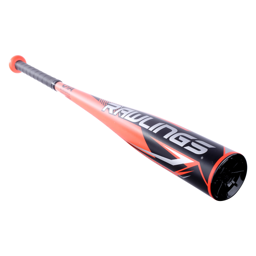

In [6]:
from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256, 256)

In [7]:
urls = search_images("cricket bat", max_images=1)
urls[0]

'https://www.sportzcraazy.com/wp-content/uploads/2019/04/SS-TON-RESERVE-EDITION-Kashmir-Willow-Cricket-Bat-4-800-1100-4-1.jpg'

In [8]:
dest = "./resources/cricket_bat.jpg"
download_url(urls[0], dest)

Path('resources/cricket_bat.jpg')

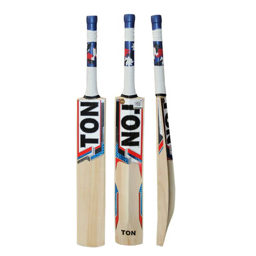

In [9]:
Image.open(dest).to_thumb(256, 256)

In [10]:
# downloading multiple images of each of the category

In [11]:
categories = ["cricket bat", "baseball bat", "tennis racket"]
path = Path("./resources/which_bat")

In [12]:
for cat in categories:
    dest = path/cat
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f"{cat} photo"))
    sleep(10)
    download_images(dest, urls=search_images(f"playing with {cat} photo"))
    sleep(10)
    download_images(dest, urls=search_images(f"posing with {cat} photo"))

In [13]:
# added max_workers argument in below code, as the earlier was raising exception broken process pool 

In [14]:
for cat in categories:
    resize_images(path/cat, max_size=400, dest=path/cat)

/home/tharun/.conda/envs/fastai/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/tharun/.conda/envs/fastai/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/tharun/.conda/envs/fastai/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Training the model

In [15]:
# !pip install nbdev

In [16]:
file_paths = get_image_files(path)
failed = verify_images(file_paths)
failed.map(Path.unlink)
len(failed)

31

In [17]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=13),
    get_y=parent_label,
    item_tfms=[Resize(192, method="squish")]
).dataloaders(path)

dls

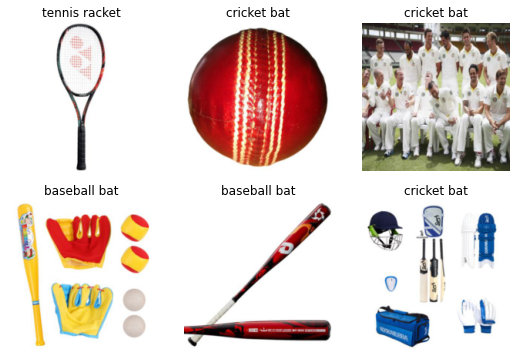

In [18]:
dls.show_batch(max_n=6)

In [19]:
learner = vision_learner(dls, resnet18, metrics=error_rate)
learner.fine_tune(3)

/home/tharun/.conda/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/tharun/.conda/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.011417,0.387525,0.132159,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.430958,0.261575,0.083700,00:03
1,0.256802,0.173899,0.063142,00:03
2,0.140442,0.175512,0.060206,00:03


## Model usage

In [20]:
def get_random_image():
    resource_path = Path("./resources/")
    return random.choice([x for x in resource_path.glob("**/*") if x.is_file()])

get_random_image()

Path('resources/which_bat/cricket bat/0b80bbc9-8d15-4952-8ab4-dc591af84b5e.jpg')

Prediction: cricket bat
Probability that it is a cricket bat is 0.9926


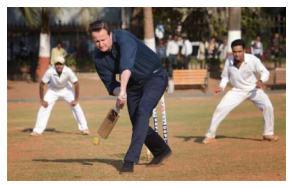

In [31]:
random_image = get_random_image()
is_which_bat, _, probs = learner.predict(PILImage.create(random_image))
show_image(Image.open(random_image))
print(f"Prediction: {is_which_bat}")

match is_which_bat:
    case "cricket bat":
        prob = probs[1]
    case "baseball bat":
        prob = probs[0]
    case "tennis racket":
        prob = probs[2]

print(f"Probability that it is a {is_which_bat} is {prob:.4f}")

In [35]:
learner.export("./models/which_bat_model.pkl")